# Introduction

In this notebook, I consider the model that has the "best" results, I train it again, and I show some interesting highlights with regard to its explainability. Indeed, the idea is to show which features are used most for the purpose of predicting the label. 

In order to do this, a cross-validation paradigm is still implemented. 

It should be noted that we aknowledge the not-so-good perform of the classifier we present, but there is not much that can be done to improve its performance, as also shown by similar results of the organizers and other entries in the leaderboard.

The model we present here is as **multi-modal model** for ECG and ST as follow:
- SVM for ECG and SVM for ST at "minute-level", i.e. with the labels unravelled;
- AdaBoost to perform the senso-temporal fusion

As such, 2 phases to explain are present: the first step is to explain which features, in the two sensors, appear to be most interesting; and the second is to figure out which timestep, and in which sensor, is the most important one for the fusion. 

It is noted how there are indeed some problematics, which are not explored: in the first step, we are only interested which features, at minute-level, can predict if a person is stressed or not for each independent sensor. For example, we will be able to tell if the *mean HR* is more important than the *std HR*, but not if it's more important than the *std ST*.
On the other hand, on the second step we will be able to tell which time in which sensor is more important, and thus tell both the most important times and sensors, but not go into detail.
Indeed, it is recognized as the main limit of our approach, but which at the same time allows for clear explainability. 

As a note, training with the whole "joined" feature sets should be tested, but has not at this moment.

# Training

In [28]:
from gc import collect as picking_trash_up
from logging import DEBUG, INFO, WARNING, basicConfig, getLogger
from os.path import basename
from os.path import join as join_paths
from sys import path
from typing import Callable

from numpy import ndarray, sqrt
from numpy.random import seed as set_seed
from pandas import DataFrame
from sklearn.base import ClassifierMixin
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

path.append("..")
from src.data.smile import SmileData
from src.models import MultiModalClassifier
from src.utils import make_binary, all_subsets
from src.utils.models import get_fusion_method, get_ml_model
from src.utils.cv import make_unravelled_folds
from src.utils.score import cross_validation
from src.utils.io import (
    create_output_folder,
    delete_output_folder_exception,
    load_config,
)
from src.utils.score import Merger

ecg_features_names: list[str] = [
    "HR mean",
    "HR HRV std R-R",
    "HR RMSE R-R diff",
    "HR low freq",
    "HR high freq",
    "HR ratio low/high freq",
    "HR ratio very low/low freq",
    "HR cycle",
]

gsr_features_names: list[str] = [
    "GSR avg",
    "GSR signal power phasic",
    "GSR response rate",
    "GSR second difference",
    "GSR #responses",
    "GSR magnitude",
    "GSR duration",
    "GSR area",
]

st_features_names: list[str] = ["ST avg", "ST std", "ST slope fitted", "ST median"]

feature_names: dict[str, list[str]] = dict(
    ECG_features=ecg_features_names,
    ST_features=st_features_names,
    GSR_features=gsr_features_names,
)

features: list[tuple[str, str]] = [
    ("hand_crafted_features", "ECG_features"),
    ("hand_crafted_features", "GSR_features"),
    ("hand_crafted_features", "ST_features"),
    ("deep_features", "ECG_features_C"),
    ("deep_features", "ECG_features_T"),
]
feature_names_short = dict(ECG_features='ECG', GSR_features='GSR', ST_features='ST')


In [3]:
set_seed(42)

path_to_config: str = f"../src/run/config_multimodal_classical_ml.yml"

configs = load_config(path=path_to_config)

cv_num: int = configs["cross_validation_folds"]
n_jobs: int = configs["n_jobs"]
n_jobs_cv: int = configs["n_jobs_cv"]
time_length: int = configs["time_length"]
path_to_data: str = configs["path_to_data"]
gaussian_process_kernel: str = configs["gaussian_process_kernel"]
fusion_methods: str | list[str] = configs["fusion_method"]
remove_sensor: str | None = configs["remove_sensor"]
binary: bool = configs["binary"]
unravelled: bool = configs["unravelled"]
debug_mode: bool = True
st_feat: bool = configs["st_feat"]
cp_all_config: bool = configs["cp_all_config"]
feature_selection: bool = configs["feature_selection"]
probability: bool = configs["probability"]
shuffle_cv: bool = configs["shuffle_cv"]
feature_selection_configs: dict = configs["feature_selection_configs"]
models_config: dict = configs["models_config"]

data = SmileData(path_to_data=join_paths("..", path_to_data), test=False, debug_mode=False)

if feature_selection:
    data.feature_selection(**feature_selection_configs)

if st_feat:
    features: list[tuple[str, str]] = [
        ("hand_crafted_features", "ECG_features"),
        ("hand_crafted_features", "GSR_features"),
        ("hand_crafted_features", "ST_features"),
    ]
else:
    features: list[tuple[str, str]] = [
        ("hand_crafted_features", "ECG_features"),
        ("hand_crafted_features", "GSR_features"),
    ]
# 2070, 60, M
if not unravelled:
    raise NotImplementedError(
        "This code is not implemented correctly for not-unravelled data."
    )

results = DataFrame(
    index=[i for i in range(cv_num)],
)

features: list[tuple[tuple[str, str], ...]] = [
    subset
    for subset in all_subsets([feat for feat in features if feat[-1] != remove_sensor])
    if len(subset) > 1
]

x: dict[str, ndarray] = data.get_handcrafted_features()
y: ndarray = data.get_labels()
if binary:
    y: ndarray = make_binary(y)

cv: list[tuple[ndarray, ndarray]] = make_unravelled_folds(
    t=time_length, n_folds=cv_num, n_data=2070, shuffle=shuffle_cv
)

if isinstance(fusion_methods, str):
    fusion_methods: list[str] = [fusion_methods]

In [4]:
fusion_methods = ['AdaBoost']
n_jobs: int = -1
n_jobs_cv: int = -1
n_repeats: int = 50

In [5]:
for fusion_method in tqdm(fusion_methods, desc="Iteration over fusion methods"):

    for feature_subset in tqdm(features, desc="Iterations over subsets"):

        current_feature_names: list[str] = [feature[1] for feature in feature_subset]
        models: list[ClassifierMixin] = {
            feature_name: get_ml_model(
                model_name=models_config[feature_name],
                gaussian_process_kernel=gaussian_process_kernel,
                n_jobs=n_jobs,
                probability=probability,
            )
            for feature_name in current_feature_names
        }
        multimodal_classifier = MultiModalClassifier(
            models=models,
            fusion_method=get_fusion_method(
                fusion_method=fusion_method,
                gaussian_process_kernel=gaussian_process_kernel,
                n_jobs=n_jobs,
                probability=probability,
            ),
            time_length=time_length,
            probability=probability,
        )

        scores = cross_validation(
            x=x, y=y, estimator=multimodal_classifier, cv=cv, n_jobs=n_jobs_cv, n_repeats=n_repeats
        )

        results[f"{current_feature_names} {fusion_method}"] = scores


Iteration over fusion methods:   0%|          | 0/1 [00:00<?, ?it/s]/Users/leonardoalchieri/Desktop/GIT/StressChallange/notebooks/../src/models/multimodal.py:62: UserWarning: Assuming fusion method to be ML based.
  warn(f"Assuming fusion method to be ML based.")
/Users/leonardoalchieri/Desktop/GIT/StressChallange/notebooks/../src/models/multimodal.py:62: UserWarning: Assuming fusion method to be ML based.
  warn(f"Assuming fusion method to be ML based.")
/Users/leonardoalchieri/Desktop/GIT/StressChallange/notebooks/../src/models/multimodal.py:62: UserWarning: Assuming fusion method to be ML based.
  warn(f"Assuming fusion method to be ML based.")
/Users/leonardoalchieri/Desktop/GIT/StressChallange/notebooks/../src/models/multimodal.py:62: UserWarning: Assuming fusion method to be ML based.
  warn(f"Assuming fusion method to be ML based.")
/Users/leonardoalchieri/Desktop/GIT/StressChallange/notebooks/../src/models/multimodal.py:62: UserWarning: Assuming fusion method to be ML based.
  

In [14]:
from numpy import mean, std, sqrt
mean_acc = mean([score[0] for score in scores])
se_acc = std([score[0] for score in scores])/sqrt(10)
print("Mean accuracy: %.2f +/- %.0f" % (mean_acc*100, se_acc*100))

Mean accuracy: 59.13 +/- 3


In [9]:
from numpy import save
from pickle import dump, load
with open('../results.nosync/importance_score_2svm_adaboost.npy', 'wb') as f:
    dump(scores, f)

## Minute-level Features

(not to run everything again)
```py
from pickle import load
with open('../results.nosync/importance_score_2svm_adaboost.npy', 'rb') as f:
    scores = load(f)
```

In [20]:
mean_minutelevel_importance_score = {
    feat_name: (
        mean([score[1][0][feat_name] for score in scores], axis=0),
        std([score[1][0][feat_name] for score in scores], axis=0) / sqrt(n_repeats),
    )
    for feat_name in current_feature_names
}


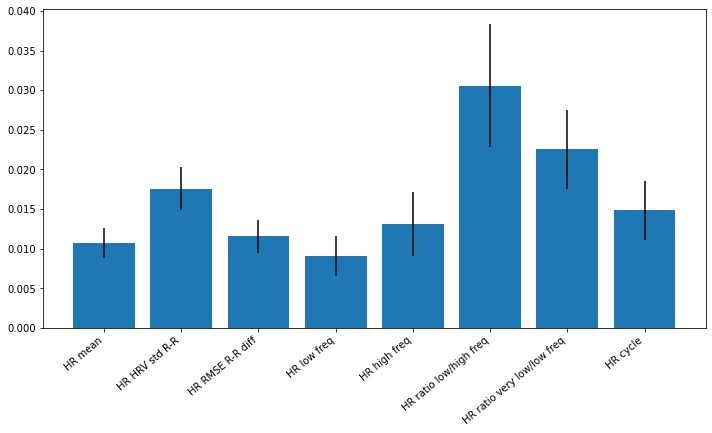

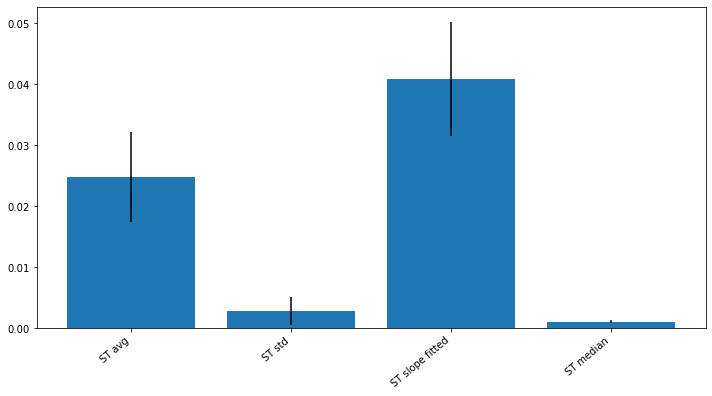

In [21]:
import matplotlib.pyplot as plt 

for data_name, (mean_score, se_score) in mean_minutelevel_importance_score.items():
    plt.figure(figsize=(10, 5))

    plt.bar(feature_names[data_name], mean_score, yerr=se_score)
    plt.tight_layout()
    plt.xticks(rotation=40, ha="right")
    plt.title(f'Feature Importance {feature_names_short[data_name]}')
    plt.savefig(f"../visualizations/feature_importance_{data_name}.pdf")
    plt.show()

These results are obtained with permutation importance, with metric the accuracy.


From these results, a few key takeways can be made:
- In the ECG classifier, the ratios between the frequencies (either low/high or very low/high) appear to be the most discriminant features; however, the frequencies themselves do not appear to help as much, while the rest is somewhat used.
- For the ST feature, only the average and the slope fitted are used by the classifier: this is somewhat in line with the results from the correltion, even though the standard deviation appeared to be more discriminanting.

A work of "finding" somewhat similar results in literature would be interesting, if possible.


## Fusion-level Features

In [15]:
mean_sensotimelevel_importance_score = (
        mean([score[1][1] for score in scores], axis=0),
        std([score[1][1] for score in scores], axis=0) / sqrt(n_repeats),
    )



In [16]:
from numpy import arange
ecg_time_idxs: ndarray = arange(0, 20, 2)
st_time_idxs: ndarray = arange(1, 20, 2)
# mean_sensotimelevel_importance_score
print(ecg_time_idxs)
print(st_time_idxs)

[ 0  2  4  6  8 10 12 14 16 18]
[ 1  3  5  7  9 11 13 15 17 19]


In [17]:
df = DataFrame(
    mean_sensotimelevel_importance_score, index=["Mean", "SRT"]
).T
df['Sensor'] = df.apply(lambda x: 'ECG' if x.name % 2 == 0 else 'ST', axis=1)
df['Time'] = df.apply(lambda x: x.name // 2, axis=1)

<AxesSubplot:xlabel='Time', ylabel='Mean'>

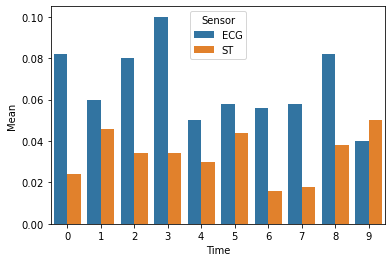

In [18]:
from seaborn import barplot, heatmap

barplot(data=df, hue='Sensor', y='Mean', x='Time')

In [21]:
mean_sensotimelevel_importance_score

(array([0.082, 0.024, 0.06 , 0.046, 0.08 , 0.034, 0.1  , 0.034, 0.05 ,
        0.03 , 0.058, 0.044, 0.056, 0.016, 0.058, 0.018, 0.082, 0.038,
        0.04 , 0.05 ]),
 array([0.00446318, 0.00277128, 0.00473286, 0.00358887, 0.004     ,
        0.00380526, 0.0060663 , 0.00311127, 0.00404969, 0.00363318,
        0.00295296, 0.00533667, 0.00375233, 0.0021166 , 0.00428019,
        0.00152315, 0.00367696, 0.00388844, 0.00309839, 0.00384708]))

In [22]:
mean_sensotimelevel_importance_score = dict(ECG_features=tuple(el[ecg_time_idxs] for el in mean_sensotimelevel_importance_score),
                                             ST_features=tuple(el[st_time_idxs] for el in mean_sensotimelevel_importance_score))

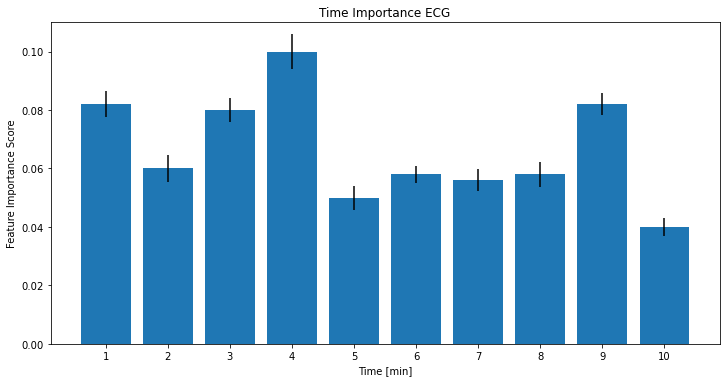

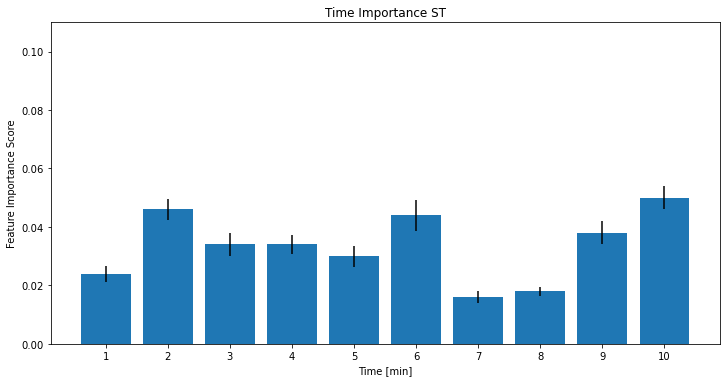

In [39]:
import matplotlib.pyplot as plt
for data_name, (mean_score, se_score) in mean_sensotimelevel_importance_score.items():
    plt.figure(figsize=(10, 5))

    x= arange(1,11)
    plt.bar(x, mean_score, yerr=se_score)
    plt.ylim(0, 0.11)
    plt.tight_layout()
    plt.xticks(x)
    plt.xlabel("Time [min]")
    plt.ylabel('Feature Importance Score')
    plt.title(f'Time Importance {feature_names_short[data_name]}')
    plt.savefig(f"../visualizations/time_importance_{data_name}.pdf")
    plt.show()

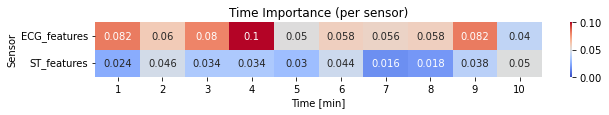

In [53]:
from seaborn import heatmap
df_to_save = DataFrame.from_dict(
    {key: val[0] for key, val in mean_sensotimelevel_importance_score.items()}
)
df_to_save.index = arange(1, 11)
df_to_save=df_to_save.T

plt.figure(figsize=(10, 1))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=0.1, vmin=0, center=0.05,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
plt.title(f"Time Importance (per sensor)")
plt.xlabel('Time [min]')
plt.ylabel('Sensor')
plt.savefig(f'../visualizations/heatmap_sensotemporal_importance.pdf')
plt.show()

From the senso-temporal analysis, a few key takeways can be made:
- The ECG sensor appears to be the most dominant out of the two, for the fusion model
- There does not appear to be a "the closer to the label, the better" narrative: indeed, for the ST sensor, no pattern is present, while for the ECG it can be said that time between 10 and 6 minutes before the label are taken as more imporant by the classifier, even though by not a large margin.

It should be noted that this outcome is not completely indicative of the facts described by the feature importanc: since the model's performance is extremely limited, they should be considered in this optic.